In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import dates as mdates

from funcs.ios import get_excel_sheet
from structs.res import AppRes

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [6]:
res = AppRes()
file = "ticks_20250819.xlsx"
path_excel = os.path.join("..", res.dir_collection, file)
code = "7011"
df = get_excel_sheet(path_excel, code)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(ts) for ts in df["Time"]])
df

,Time,Price,Volume
2025-08-19 09:01:17.689856,1.755562e+09,4036,1826100
2025-08-19 09:01:18.692876,1.755562e+09,4036,1826100
2025-08-19 09:01:19.675019,1.755562e+09,4031,1879100
2025-08-19 09:01:20.672993,1.755562e+09,4031,1879100
2025-08-19 09:01:21.687569,1.755562e+09,4030,1895200
...,...,...,...
2025-08-19 15:24:55.392636,1.755585e+09,3913,25373500
2025-08-19 15:24:56.383619,1.755585e+09,3913,25373500
2025-08-19 15:24:57.386104,1.755585e+09,3915,25377000
2025-08-19 15:24:58.392595,1.755585e+09,3915,25377000


## 株価そのまま

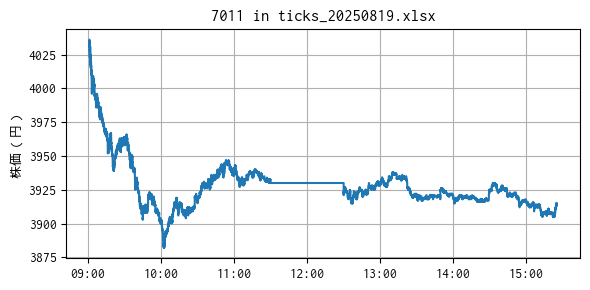

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["Price"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("株価（円）")
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

## 株価比

In [8]:
price_open = df.iloc[0]["Price"]
price_open

np.float64(4036.0)

In [9]:
df["PriceRatio"] = ((df["Price"] / price_open) - 1) * 25
# df["PriceRatio"] = np.tanh(((df["Price"] / price_open) - 1) * 25)
df

,Time,Price,Volume,PriceRatio
2025-08-19 09:01:17.689856,1.755562e+09,4036,1826100,0.000000
2025-08-19 09:01:18.692876,1.755562e+09,4036,1826100,0.000000
2025-08-19 09:01:19.675019,1.755562e+09,4031,1879100,-0.030971
2025-08-19 09:01:20.672993,1.755562e+09,4031,1879100,-0.030971
2025-08-19 09:01:21.687569,1.755562e+09,4030,1895200,-0.037166
...,...,...,...,...
2025-08-19 15:24:55.392636,1.755585e+09,3913,25373500,-0.761893
2025-08-19 15:24:56.383619,1.755585e+09,3913,25373500,-0.761893
2025-08-19 15:24:57.386104,1.755585e+09,3915,25377000,-0.749504
2025-08-19 15:24:58.392595,1.755585e+09,3915,25377000,-0.749504


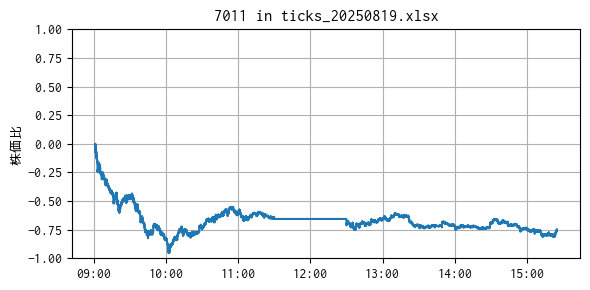

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["PriceRatio"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("株価比")
ax.set_ylim(-1, 1)
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

## 制限値幅を使う → 前日終値と本日始値の平均で割る

### 前日の終値

In [11]:
# 前日のOHLC
def get_last_ohlc(file: str, code: str) -> pd.DataFrame:
    pattern = re.compile(r"ticks_(\d{4})(\d{2})(\d{2})\.xlsx")
    if m := pattern.match(file):
        yr = m.group(1)
        mo = m.group(2)
        dy = m.group(3)
    else:
        yr = "1970"
        mo = "01"
        dy = "01"
    date_end = f"{yr}-{mo}-{dy}"
    ticker = yf.Ticker(f"{code}.T")
    return ticker.history(period="10d", interval="1d", end=date_end).tail(1)

In [12]:
df_last = get_last_ohlc(file, code)
df_last

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-08-18 00:00:00+09:00,3927.747945,4025.443199,3922.763493,3940.70752,33163000,0.0,0.0


In [13]:
price_lastclose = int(df_last.iloc[0]["Close"])
price_lastclose

3940

In [14]:
df.iloc[0]["Price"] - price_lastclose

np.float64(96.0)

In [15]:
file_price_limit = "tse_daily_price_limit.csv"
path_csv = os.path.join("..", res.dir_info, file_price_limit)
df_price_limit = pd.read_csv(path_csv)
df_price_limit

,price_max,range
0,100,30
1,200,50
2,500,80
3,700,100
4,1000,150
5,1500,300
6,2000,400
7,3000,500
8,5000,700
9,7000,1000


In [16]:
price_range = (
    df_price_limit[df_price_limit["price_max"] >= price_lastclose]
    .head(1)
    .iloc[0]["range"]
)
price_range

np.int64(700)

In [17]:
df["PriceNorm"] = (df["Price"] - price_lastclose) / price_range * 10
df["PriceNorm"].min(), df["PriceNorm"].max()

(np.float64(-0.8285714285714285), np.float64(1.3714285714285714))

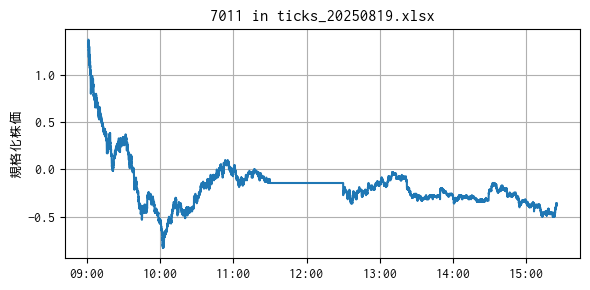

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["PriceNorm"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("規格化株価")
# ax.set_ylim(-1, 1)
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

## 始値からどの程度変動するのか？

In [50]:
df_summary = pd.DataFrame(
    {
        "file": [],
        "lastday": [],
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "range": [],
    }
)
code = "7011"
files = sorted(os.listdir(os.path.join("..", res.dir_collection)))
for file in files:
    path_excel = os.path.join("..", res.dir_collection, file)
    code = "7011"
    df = get_excel_sheet(path_excel, code)
    df.index = pd.to_datetime(
        [datetime.datetime.fromtimestamp(ts) for ts in df["Time"]]
    )
    price_open = df.iloc[0]["Price"]

    # 前日の終値
    df_last = get_last_ohlc(file, code)
    price_lastclose = df_last.iloc[0]["Close"]
    dt_last = df_last.index[-1]
    day_last = f"{dt_last.year:4d}-{dt_last.month:02d}-{dt_last.day:02d}"

    df["PriceRatio"] = (df["Price"] / price_open) - 1
    r = len(df_summary)
    df_summary.loc[r] = [
        file,
        day_last,
        df["PriceRatio"].mean(),
        df["PriceRatio"].std(),
        df["PriceRatio"].min(),
        df["PriceRatio"].max(),
        df["PriceRatio"].max() - df["PriceRatio"].min(),
    ]
df_summary

,file,lastday,mean,std,min,max,range
0,ticks_20250819.xlsx,2025-08-18,-0.026932,0.004673,-0.038157,0.000000,0.038157
1,ticks_20250820.xlsx,2025-08-19,-0.000019,0.002967,-0.012304,0.007068,0.019372
2,ticks_20250821.xlsx,2025-08-20,-0.005019,0.002935,-0.011752,0.008618,0.020371
3,ticks_20250822.xlsx,2025-08-21,-0.000948,0.003729,-0.006776,0.006776,0.013552
4,ticks_20250825.xlsx,2025-08-22,-0.016042,0.002468,-0.019360,0.000000,0.019360
5,ticks_20250826.xlsx,2025-08-25,-0.010741,0.004273,-0.015187,0.003928,0.019115
6,ticks_20250827.xlsx,2025-08-26,-0.006208,0.002799,-0.011352,0.004752,0.016103
7,ticks_20250828.xlsx,2025-08-27,0.014265,0.005026,-0.006972,0.020649,0.027621
8,ticks_20250829.xlsx,2025-08-28,-0.003155,0.003439,-0.008203,0.007939,0.016142
9,ticks_20250901.xlsx,2025-08-29,0.008446,0.009511,-0.003227,0.034418,0.037645


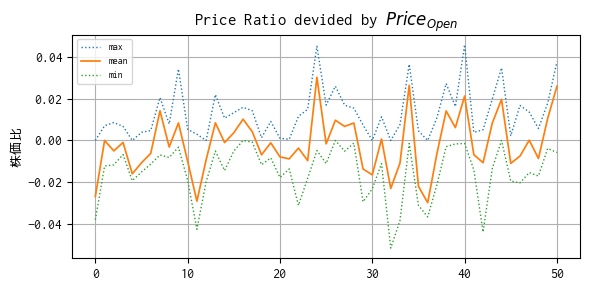

In [55]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_summary["max"], linewidth=1, linestyle="dotted", label="max")
ax.plot(df_summary["mean"], linewidth=1.25, linestyle="solid", label="mean")
ax.plot(df_summary["min"], linewidth=1, linestyle="dotted", label="min")
ax.set_ylabel("株価比")
ax.grid()
ax.legend(fontsize=7)
ax.set_title("Price Ratio devided by ${Price}_{Open}$")
plt.tight_layout()
plt.show()